# Predicción de Cancelación de Clientes (Churn)

## Introducción
Este proyecto busca anticiparse al problema de la cancelación de clientes. Para ello vamos a desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios. 

### Vamos a desarrollar: 
- Prepararación de los datos para el modelado (tratamiento, codificación, normalización).
- Realización del análisis de correlación y selección de variables.
- Entrenar dos o más modelos de clasificación.
- Evaluar el rendimiento de los modelos con métricas.
- Interpretar los resultados, incluyendo la importancia de las variables.
- Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

El archivo base para el análisis será `TelecomX_Data_tratado.csv`.

In [1]:
import pandas as pd

# Cargar el archivo de datos
ruta = 'data/TelecomX_Data_tratado.csv'
df = pd.read_csv(ruta)
df.head()

# Identificar variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Variables categóricas:', cat_cols)

# Transformar variables categóricas a formato numérico (one-hot encoding)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head()

Variables categóricas: ['customerID', 'Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,Tenure,MonthlyCharges,TotalCharges,DailyCharges,Churn_numeric,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,9,65.6,593.30,2.186667,0.0,False,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
1,9,59.9,542.40,1.996667,0.0,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,4,73.9,280.85,2.463333,1.0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,13,98.0,1237.85,3.266667,1.0,False,False,True,False,False,...,False,True,False,True,False,False,True,False,True,False
4,3,83.9,267.40,2.796667,1.0,False,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True


## Verificación de la Proporción de Cancelación (Churn)

Proporción de cancelación (Churn):
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


<Axes: title={'center': 'Proporción de Cancelación (Churn)'}, xlabel='Churn'>

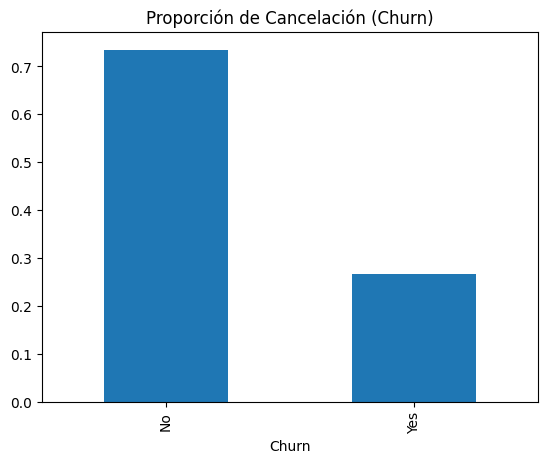

In [2]:


churn_counts = df['Churn'].value_counts(normalize=True)

print('Proporción de cancelación (Churn):')

print(churn_counts)



churn_counts.plot(kind='bar', title='Proporción de Cancelación (Churn)')